Extracting /root/PycharmProjects/test/MNIST_data/train-images-idx3-ubyte.gz


Extracting /root/PycharmProjects/test/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /root/PycharmProjects/test/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/PycharmProjects/test/MNIST_data/t10k-labels-idx1-ubyte.gz


Tensor("loss_9/Neg:0", shape=(), dtype=float32)


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ; 数字= 6


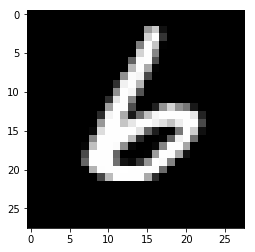

result:  Tensor("layer_18/Wx_plus_b/result:0", shape=(?, 10), dtype=float32)
input_labels:  Tensor("inputs_18/input_labels:0", shape=(?, 10), dtype=float32)
正确率 0.9137


In [25]:
# ImportError: No module named input_data
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
# Just disables the warning, doesn't enable AVX/FMA
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# 显示图片
def show_bmp(im_arr):
    # 参考：http://blog.csdn.net/u010194274/article/details/50817999
    im = np.array(im_arr)
    im = im.reshape(28, 28)

    # fig = plt.figure()
    # plotwindow = fig.add_subplot(111)

    plt.imshow(im, cmap='gray')
    plt.show()


def show_loge(val):
    plt.figure(1)
    plt.plot(val, np.log(val), 'b--')
    plt.show()


# 为了用于这个教程，我们使标签数据是"one-hot vectors"。 
# 一个 one_hot 向量除了某一位的数字是1以外其余各维度数字都是0。
# one_hot 标签则是顾名思义，一个长度为n的数组，只有一个元素是1.0，其他元素是0.0。
# 所以在此教程中，数字n将表示成一个只有在第n维度（从0开始）数字为1的10维向量。比如，标签0将表示成([1,0,0,0,0,0,0,0,0,0])。
mnist = input_data.read_data_sets('/root/PycharmProjects/test/MNIST_data', one_hot=True)

# x不是一个特定的值，而是一个占位符placeholder，我们在TensorFlow运行计算时输入这个值。
# 我们希望能够输入任意数量的MNIST图像，每一张图展平成784维的向量。
# 我们用2维的浮点数张量来表示这些图，这个张量的形状是[None，784 ]。（这里的None表示此张量的第一个维度可以是任何长度的。）
with tf.name_scope('inputs'):
    input_images = tf.placeholder("float", [None, 784], name='input_images')
    # 为了后面计算交叉熵，我们首先需要添加一个新的占位符用于输入正确值
    input_labels = tf.placeholder("float", [None, 10], name='input_labels')

with tf.name_scope('layer'):
    with tf.name_scope('weights'):
        # 在这里，我们都用全为零的张量来初始化W和b。因为我们要学习W和b的值，它们的初值可以随意设置。
        W = tf.Variable(tf.zeros([784, 10]), name='W')
    with tf.name_scope('biases'):  
        b = tf.Variable(tf.zeros([10]), name='b')
    with tf.name_scope('Wx_plus_b'):
        # 首先，我们用tf.matmul(​​X，W)表示x乘以W，对应之前等式里面的，这里x是一个2维张量拥有多个输入。然后再加上b，把和输入到tf.nn.softmax函数里面。
        # 至此，我们先用了几行简短的代码来设置变量，然后只用了一行代码来定义我们的模型。
        # TensorFlow不仅仅可以使softmax回归模型计算变得特别简单，它也用这种非常灵活的方式来描述其他各种数值计算，从机器学习模型对物理学模拟仿真模型。
        # 一旦被定义好之后，我们的模型就可以在不同的设备上运行：计算机的CPU，GPU，甚至是手机！
        result = tf.nn.softmax(tf.matmul(input_images, W) + b, name='result')
    
with tf.name_scope('loss'):
    # 注意，tf.reduce_sum把minibatch里的每张图片的交叉熵值都加起来了。我们计算的交叉熵是指整个minibatch的。
    # 计算交叉熵（越小越好 ，注意 cross_entropy 等于负数，所以 tf.reduce_sum(y_ * tf.log(y)) 越大越好）: 
    # 交叉熵可在神经网络(机器学习)中作为损失函数，p表示真实标记的分布，q则为训练后的模型的预测标记分布，交叉熵损失函数可以衡量p与q的相似性。
    # 交叉熵作为损失函数还有一个好处是使用sigmoid函数在梯度下降时能避免均方误差损失函数学习速率降低的问题，因为学习速率可以被输出的误差所控制。
    cross_entropy = -tf.reduce_sum(input_labels * tf.log(result), name='cross_entropy')
    # 要想明白交叉熵(Cross Entropy)的意义，可以从熵(Entropy) -> KL散度(Kullback-Leibler Divergence) -> 交叉熵这个顺序入手。
    # 当然，也有多种解释方法[1]。
    # 先给出一个“接地气但不严谨”的概念表述：
    #  - 熵：可以表示一个事件A的自信息量，也就是A包含多少信息。
    #  - KL散度：可以用来表示从事件A的角度来看，事件B有多大不同。
    #  - 交叉熵：可以用来表示从事件A的角度来看，如何描述事件B。
    print(cross_entropy)

with tf.name_scope('train'):
    # 学习时，使用梯度下降优化器算法，要求 cross_entropy（交叉熵）值最小
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# 变量需要通过seesion初始化后，才能在session中使用。
# 这一初始化步骤为，为初始值指定具体值（本例当中是全为零），并将其分配给每个变量,可以一次性为所有变量完成此操作
init = tf.global_variables_initializer()

sess = tf.Session()

# 开始初始化变量
sess.run(init)

writer = tf.summary.FileWriter("/root/PycharmProjects/logs", sess.graph)

# 用于将 one-hot向量 变为数字（可以忽略）
mask = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    if i % 2000 == 0:  # 为了防止打印图片影响性能，则每隔2000个，打印一下图片
        # 显示标签的 one-hot 向量 及其 数字
        print(batch_ys[0], '; 数字=', np.matmul(batch_ys[0], mask).astype(np.uint))
        # 显示数字的图片
        show_bmp(batch_xs[0])
        # 输入 feed_dict 数据，进行学习
    sess.run(train_step, feed_dict={input_images: batch_xs, input_labels: batch_ys})

# argmax 返回的是最大数的索引.argmax 有一个参数axis=1,表示第1维的最大值.
correct_prediction = tf.equal(tf.argmax(result, 1), tf.argmax(input_labels, 1), name='correct_prediction')

print('result: ', result)
print('input_labels: ', input_labels)

# 这里返回一个布尔数组。
# 为了计算我们分类的准确率，我们将布尔值转换为浮点数来代表对、错，然后取平均值。
# 例如：[True, False, True, True]变为[1,0,1,1]，计算出平均值为0.75
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='accuracy')

# 最后，我们计算所学习到的模型在测试数据集上面的正确率。
print('正确率', sess.run(accuracy, feed_dict={input_images: mnist.test.images, input_labels: mnist.test.labels}))

sess.close()
